In [1]:
import os 
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# resizing the image
Size_X = 128
Size_Y = 128
n_classes = 2

In [3]:
#from keras.utils import normalize
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(BACKBONE)

2022-06-14 20:56:02.328835: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Segmentation Models: using `tf.keras` framework.


In [4]:
gpus = tf.config.list_physical_devices()
gpus

2022-06-14 19:24:19.402457: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-06-14 19:24:19.449307: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-14 19:24:19.450369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-14 19:24:19.451275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:2', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:3', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [5]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [5]:
#model = sm.PSPNet(BACKBONE, encoder_weights = None, classes =3 ,encoder_freeze=False, activation='sigmoid',input_shape=(Size_X,Size_Y,3), downsample_factor=8,psp_conv_filters=512, psp_pooling_type='avg',psp_use_batchnorm=True,psp_dropout=0.2)
model = sm.Unet(BACKBONE, encoder_weights = 'imagenet', classes =3 ,encoder_freeze=False,input_shape=(128,128,3),activation='softmax')
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.IOUScore(class_indexes=2,per_image=True),sm.metrics.FScore(class_indexes=2,per_image=True),sm.metrics.Precision(class_indexes=2),sm.metrics.Recall(class_indexes=2)],)
print(model.summary())

2022-06-14 20:56:13.790103: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-06-14 20:56:13.856827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-14 20:56:13.857981: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-14 20:56:13.859120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 48)   1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 48)   192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 48)   0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [8]:
# define model
model = sm.PSPNet(BACKBONE, encoder_weights = None, classes =3 ,encoder_freeze=False, activation='softmax',input_shape=(Size_Y,Size_X,3), downsample_factor=8,psp_conv_filters=512, psp_pooling_type='avg',psp_use_batchnorm=True,psp_dropout=0.2)
model.compile('Adam', loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.IOUScore(class_indexes=2),sm.metrics.FScore(class_indexes=2),sm.metrics.Precision(class_indexes=2),sm.metrics.Recall(class_indexes=2)])
print(model.metrics_names)

[]


In [6]:
model.load_weights('weights/last/effb4_unet240.h5')

slices to test
97_568
97_597
98_565
129_104

In [7]:
def togray(mask_gen):
  mask_gen[mask_gen[:,:,0]>0.1,0]=0 
  mask_gen[mask_gen[:,:,1]>0.1,1]=1
  mask_gen[mask_gen[:,:,2]>0.1,2]=2
  res=mask_gen[:,:,0]+mask_gen[:,:,1]+mask_gen[:,:,2]
  res=res.astype(np.uint8)
  res = cv2.resize(res, (512, 512))
  return res
def gray2(mask):
    res=np.zeros((mask.shape[0],mask.shape[1]))
    for i in range (0,mask.shape[0]):
        for j in range (0,mask.shape[1]):
            l=np.argmax([mask[i,j,0],mask[i,j,1],mask[i,j,2]])
            res[i,j]=l
    res=res.astype(np.uint8)
    res = cv2.resize(res, (512, 512))
    return res


2022-06-14 20:57:07.588700: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-06-14 20:57:08.862460: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


(128, 128, 3)
(array([0, 1, 2], dtype=uint8), array([216537,  36791,   8816]))
inference time is:4024.991273880005ms


[]

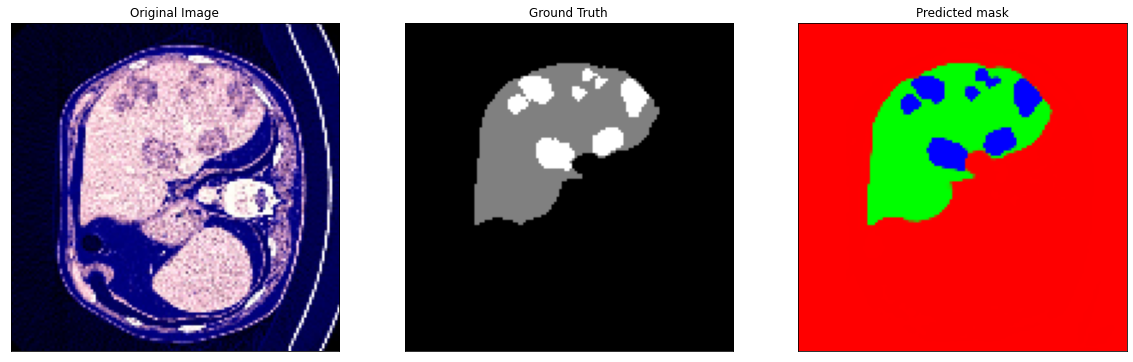

In [8]:
import time
#Test on a different image
#READ EXTERNAL IMAGE...
start =time.time()
test_img = cv2.imread('new/Train_img/liver/volume-97_slice_568.jpg')       
test_img = cv2.resize(test_img, (Size_Y, Size_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img1 = np.expand_dims(test_img/255.0, axis=0)

prediction = model.predict(test_img1)
img1=prediction.reshape((Size_Y, Size_X,3))
img=gray2(img1)
print(img1.shape)
cv2.imwrite("testing1.tiff",img)
print(np.unique(img,return_counts=True))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
end=time.time()
inference=(end-start)*1000
print("inference time is:"+str(inference)+"ms")

mask_img = cv2.imread('new/Train_img/liver_mask/segmentation-97_slice_568.tiff',0)       
mask_img = cv2.resize(mask_img, (Size_Y, Size_X))
fig, ax= plt.subplots(1,3,figsize=(20, 20))
ax[0].imshow(test_img, cmap='gray')
ax[0].set(title='Original Image')
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[1].imshow(mask_img, cmap='gray')
ax[1].set(title='Ground Truth')
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[2].imshow(img1, cmap='gray')
ax[2].set(title='Predicted mask')
ax[2].xaxis.set_ticks([])
ax[2].yaxis.set_ticks([])
 

In [67]:
#capturing training image info as a list
count = 0;
test_images = []
#val_frames/val_frames
#new/test/test_frames/
for dir_path in glob.glob('val_frames/val_frames/'):
  for img_path in sorted(glob.glob(os.path.join(dir_path+'*.jpg'))):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (Size_Y, Size_X))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images.append(img)
    count+=1
    #if(count == 4000):
     # break;
#conver list to array for machine learning processing
test_images = np.array(test_images)
count = 0
test_masks = [] 
#val_masks/val_masks
#new/test/test_masks/
for dir_path in glob.glob("val_masks/val_masks/"):
    for mask_path in sorted(glob.glob(os.path.join(dir_path+'*.tiff'))):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (Size_Y, Size_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        test_masks.append(mask)
        count+=1
        #if(count == 4000):
         # break;
        #train_labels.append(label)
#Convert list to array for machine learning processing          
test_masks = np.array(test_masks)

In [ ]:
U = test_images
V = test_masks
#X = np.expand_dims(X, axis=3)
V = np.expand_dims(V, axis=3)

In [ ]:
from keras.utils import to_categorical
test_masks_cat = to_categorical(V)
v_train_cat = test_masks_cat.reshape((V.shape[0], V.shape[1], V.shape[2], 3))

In [ ]:
results = model.evaluate(U,test_masks_cat, batch_size=32)
results

In [3]:
2==2.0

True

# CRF post processing

In [15]:
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Using cached Cython-0.29.30-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-oh3hdhpp
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-oh3hdhpp
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2907760 sha256=f3f49e38d764048dce3de6fef287c81bf81f58cce0b625fb31a89cad7cf67049
  Stored in directory: /tmp/pip-ephem-wheel-cache-ueujjrb0/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf


In [16]:
import numpy as np
import pydensecrf.densecrf as dcrf
import matplotlib.pyplot as plt

In [17]:
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
import cv2
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
#from osgeo import gdal
%matplotlib inline

In [131]:
X=cv2.imread("new/Train_img/liver/volume-97_slice_568.jpg")
#X=test_img
y=cv2.imread("testing1.tiff")
# out=cv2.imread("C:\Aashish\Assignments\Machine Learning\CRF - DataSet\20_actual.png")

In [132]:
"""
Function which returns the labelled image after applying CRF

"""

#Original_image = Image which has to labelled
#Annotated image = Which has been labelled by some technique( FCN in this case)
#Output_image = Name of the final output image after applying CRF
#Use_2d = boolean variable 
#if use_2d = True specialised 2D fucntions will be applied
#else Generic functions will be applied

def crf(original_image, annotated_image,output_image, use_2d = True):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(annotated_image.shape)<3):
        annotated_image = gray2rgb(annotated_image).astype(np.uint32)
    
    cv2.imwrite("testing2.tiff",annotated_image)
    annotated_image = annotated_image.astype(np.uint32)
    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = annotated_image[:,:,0].astype(np.uint32) + (annotated_image[:,:,1]<<8).astype(np.uint32) + (annotated_image[:,:,2]<<16).astype(np.uint32)
    
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
    
    #Creating a mapping back to 32 bit colors
    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16
    
    #Gives no of class labels in the annotated image
    n_labels = len(set(labels.flat)) 
    
    print("No of labels in the Image are ")
    print(n_labels)
    
    
    #Setting up the CRF model
    if use_2d :
        d = dcrf.DenseCRF2D(out.tiffriginal_image.shape[1], original_image.shape[0], n_labels)

        # get unary potentials (neg log probability)
        U = unary_from_labels(labels, n_labels, gt_prob=0.90, zero_unsure=False)
        d.setUnaryEnergy(U)

        # This adds the color-independent term, features are the locations only.
        d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

        # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
        d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=original_image,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 5 steps 
    Q = d.inference(1)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    # Convert the MAP (labels) back to the corresponding colors and save the image.
    # Note that there is no "unknown" here anymore, no matter what we had at first.
    MAP = colorize[MAP,:]
    cv2.imwrite(output_image,MAP.reshape(original_image.shape))
    return MAP.reshape(original_image.shape)

In [133]:
crfimage = crf(X,y,"out.tiff")

No of labels in the Image are 
3


In [134]:
np.unique(crfimage,return_counts=True)

(array([0, 1, 2], dtype=uint8), array([649812, 112572,  24048]))

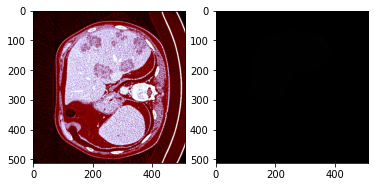

In [135]:
plt.subplot(1,2,1)
plt.imshow(X)
plt.subplot(1,2,2)
plt.imshow(crfimage,cmap='gray')